# calculating return periods and values from lmoments

In [1]:
import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import lmoments3 as lm
from lmoments3 import distr

import matplotlib.pyplot as plt
%matplotlib inline

## extracting time series from netcdf file

In [2]:
ds = xr.open_dataset("./data/pr_Amon_NorESM1-M_historical_r1i1p1_185001-200512.nc")
print(ds)

<xarray.Dataset>
Dimensions:    (time: 1872, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/26)
    institution:            Norwegian Climate Centre
    institute_id:           NCC
    experiment_id:          historical
    source:                 NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-n...
    model_id:               NorESM1-M
    forcing:                GHG, SA, Oz, Sl, Vl, BC, OC
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  NorESM1-M mo

In [3]:
# converting precipitation to m/day units

ds["pr"].data = ds["pr"].data * 86.4
ds["pr"].attrs["units"] = 'm/day' 

In [4]:
# getting dataset specifically for defined location
# coordinates for berkeley, california

lat = 37.87
lon = 122.27
ds_berk = ds.sel(lon=lon, lat=lat, method='nearest')

In [5]:
# converting to timeseries dataframe

sr = ds_berk['pr'].to_pandas()
sr.index = sr.index.to_datetimeindex()
df = pd.DataFrame({'time':sr.index, 'pr':sr.values})

/var/folders/bz/l7frggbx71n9k19wxh7hvwsm0000gn/T/ipykernel_30247/1416090827.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sr.index = sr.index.to_datetimeindex()


## using l-moments to calculate return periods and return values

### preparing data and fitting to gev (generalized extreme value) distribution

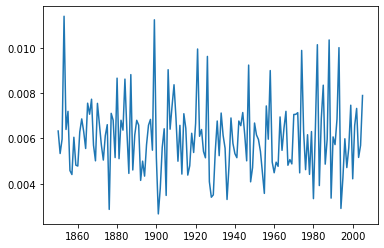

In [6]:
# get annual max series (ams)
# used to fit distribution later

ams = df.groupby([df.time.dt.year])['pr'].max()
plt.plot(ams)

In [7]:
# calculate l-moment ratios

lm_params = lm.lmom_ratios(ams)
lm_params

[0.006057047895573748,
 0.000903697250338889,
 0.10480526361599214,
 0.17371228989598222,
 0.06690049741221984]

In [8]:
# fit to gev distribution

paras = distr.gev.lmom_fit(ams)
fitted_gev = distr.gev(**paras)

### using cdf (cumulative distribution function) take a return value and calculate exceedance and return period

In [68]:
# assuming the climate has been stationary over historical period
# calculating how likely in a given year it is to experience a 0.009 m/day exceedance
# the probability of exceeding a threshold of 0.009 m/day in berkeley

return_value_threshold = 0.009

exceedance = fitted_gev.cdf(return_value_threshold)
exceedance_probability = 1-exceedance
exceedance_probability = "{:.5%}".format(exceedance_probability)
exceedance_probability

'5.02444%'

In [69]:
# calculate corresponding return period for exceedance value

return_period = -1.0/(exceedance-1.0)
return_period = round(return_period)
print ('1 in a',return_period,'year event')

1 in a 20 year event


### using ppf (inverse distribution function or quantile function) to calculate exceedance threshold from return period

In [71]:
# what m/day has a probability of being exceeded in a given year of 1%
# calculate the value of a 100 year event 

return_year = 100
return_period = 1.0-(1./return_year)

threshold = fitted_gev.ppf(return_period)
threshold = round(threshold, 5)
print('for a 1 in a',return_year,'year event, a',threshold,'(m) precipitation event is expected')

for a 1 in a 100 year event, a 0.01057 (m) precipitation event is expected


### plotting extreme values according to return years

In [66]:
# calculate return periods for return years 2, 5, 10, 20, 50, 100, 200, 500, and 1000

return_years = [2,5,10,20,50,100,200,500,1000]
return_periods = np.empty(len(return_years))

for i in range(len(return_years)):
    return_periods[i] = 1.0-(1.0/return_years[i])

gev_return_periods = fitted_gev.ppf(return_periods)

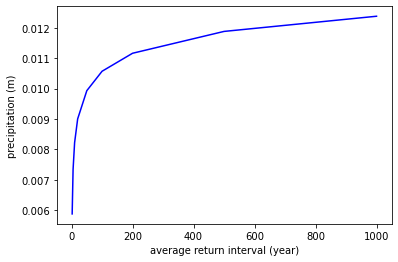

In [67]:
plt.xlabel('average return interval (year)')
plt.ylabel('precipitation (m)')

plt.plot(return_years, gev_return_periods, 'b', label='gev')

In [42]:
# calculate return periods for return years (1.1 to 1000)

return_year_range = np.arange(0.1, 999.1, 0.1) + 1
return_period_range = 1.0-(1.0/return_year_range)
gev_return_periods = fitted_gev.ppf(return_period_range)

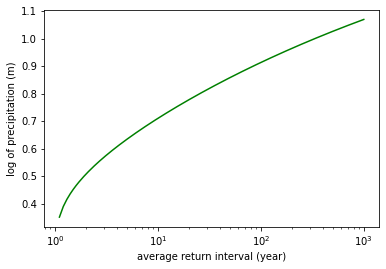

In [43]:
# plot log transformation of return years

plt.xscale('log')
plt.xlabel('average return interval (year)')
plt.ylabel('log of precipitation (m)')

plt.plot(return_year_range, gev_return_periods, 'g', label='gev')

### fitting and plotting to a variety of distributions

In [49]:
# fit to gev (generalized extreme value), gum (gumbel), wei (weibull)
# gam (gamma), gpa (generalized pareto), exp (exponentional)
# and generalized lgositics (glo) distributions

paras_gev = distr.gev.lmom_fit(ams)
paras_gum = distr.gum.lmom_fit(ams)
paras_wei = distr.wei.lmom_fit(ams)
paras_gam = distr.gam.lmom_fit(ams)
paras_gpa = distr.gpa.lmom_fit(ams)
paras_exp = distr.exp.lmom_fit(ams)
paras_glo = distr.glo.lmom_fit(ams)

fitted_gev = distr.gev(**paras_gev)
fitted_gum = distr.gum(**paras_gum)
fitted_wei = distr.wei(**paras_wei)
fitted_gam = distr.gam(**paras_gam)
fitted_gpa = distr.gpa(**paras_gpa)
fitted_exp = distr.exp(**paras_exp)
fitted_glo = distr.glo(**paras_glo)

In [50]:
# calculate return periods for return years (1.1 to 1000)

return_year_range = np.arange(0.1, 999.1, 0.1) + 1
return_period_range = 1.0-(1.0/return_year_range)

In [51]:
# get return period values for different distributions

gev_return_periods = fitted_gev.ppf(return_period_range)
gum_return_periods = fitted_gum.ppf(return_period_range)
wei_return_periods = fitted_wei.ppf(return_period_range)
gam_return_periods = fitted_gam.ppf(return_period_range)
gpa_return_periods = fitted_gpa.ppf(return_period_range)
exp_return_periods = fitted_exp.ppf(return_period_range)
glo_return_periods = fitted_glo.ppf(return_period_range)

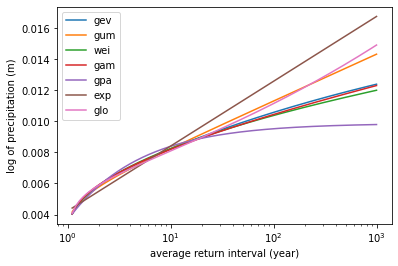

In [52]:
# plot log transformation of return years

plt.xscale('log')
plt.xlabel('average return interval (year)')
plt.ylabel('log of precipitation (m)')

line1, = plt.plot(return_year_range, gev_return_periods, label='gev')
line2, = plt.plot(return_year_range, gum_return_periods, label='gum')
line3, = plt.plot(return_year_range, wei_return_periods, label='wei')
line4, = plt.plot(return_year_range, gam_return_periods, label='gam')
line5, = plt.plot(return_year_range, gpa_return_periods, label='gpa')
line6, = plt.plot(return_year_range, exp_return_periods, label='exp')
line7, = plt.plot(return_year_range, glo_return_periods, label='glo')

plt.legend()